# Spherical Collapse in Radiation Domination

Here we reproduce the results from https://arxiv.org/abs/astro-ph/9403011

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.integrate import odeint
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.interpolate import interp1d

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=16)

main_line_color = "#e96859"
main_line_color2 = "#9546ca"
main_line_color3 = "#00cc00"

path_effects=[pe.Stroke(linewidth=4.4, foreground='k'), pe.Normal(), 
              pe.SimpleLineShadow(alpha = 0.1, offset=(2,-2))]

In [2]:
def nonlinearODE(y, x, delta_i, cosmology, tol, verbose = 0):
    Omega_L, Omega_M, Omega_R = cosmology
    
    R, dRdx = y
    R = abs(R)
    omega = Omega_L*Omega_R**3/Omega_M**4
    
    A = x*(x+1+omega*x**4)
    B = 0.5*(1-omega*x**3)
    C = -(3/2*x + 1 + 3*omega*x**4)
    
        
    if R > tol:
        d2Rdx2 =  1/A*(-0.5*(1+delta_i)/R**2 + B*R + C*dRdx)
    else:
        d2Rdx2 =  0
        dRdx = 0

    return [dRdx, d2Rdx2]

def find_collapse(x, phis, cosmology, tol):
    xcol = np.zeros(len(phis))
    mask = np.ones(len(phis), dtype=bool)
    for i, phi in enumerate(phis):
        y0 = [1, 0]
        psoln = odeint(nonlinearODE, y0, x, args=(phi, cosmology,  tol, 0))
        R = psoln[:,0];
        
        if sum(R<=tol) > 0:
            R[R<=tol] = 0
            xcol[i] = max(x[R>0])
            if xcol[i] == 0:
                print("Error: xcol[i] == 0\nInfo: delta_i = {:.3}, cosmology = {}".format(phi, cosmology))
        else:
            mask[i] = False
            #print("FALSE!")
    
    return xcol, mask


C:\Users\david\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\david\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\david\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


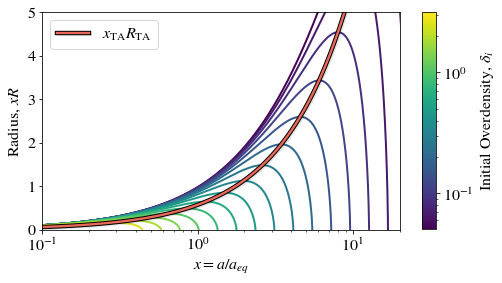

In [3]:
# cosmologies 
planck2015 = [0.6911, 0.3089, 9.16e-5]
noDE = [0.0,0.3,8.486e-5]

cmap = "viridis"
colormap = plt.get_cmap(cmap) 
cNorm  = colors.LogNorm(10**(-1.3), 10**(0.5))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

x = np.logspace(-4, 4, 1000000)
y0 = [1, 0]
tol = 1e-7

plt.figure(figsize = (8,4))

xTAs = []
RTAs = []
phis = np.logspace(-1.3, 1, 20)
for phi in phis:
    psoln = odeint(nonlinearODE, y0, x, args=(phi, noDE,  tol, 0))
    color = scalarMap.to_rgba(phi)
    R = psoln[:,0];
    dRdx = psoln[:,1]
    xcol = max(x[x*R > 0.005])
    R[x > xcol] = np.nan
    if phi < 10**(0.5):
        plt.semilogx(x, x*R, lw = 2, color = color)
    xTA = x[x*R == max(x*R)][0]
    xTAs.append(xTA)
    RTAs.append(R[x == xTA][0])
plt.ylim(-0, 5)
plt.xlim(1e-1, 2e1)
plt.ylabel("Radius, $xR$");
plt.xlabel("$x = a/a_{eq}$");
xTAs = np.asarray(xTAs)
RTAs = np.asarray(RTAs)


Cx = xTAs*phis
xRta = interp1d(np.log10(xTAs),xTAs*RTAs, kind = "cubic")

xDummy = np.logspace(-1, 1, 100)

plt.plot(xDummy, xRta(np.log10(xDummy)), lw = 2.4, color = "#e96859", 
         path_effects = path_effects, label = "$x_{\mathrm{TA}}R_{\mathrm{TA}}$")
plt.colorbar(scalarMap, label = "Initial Overdensity, $\delta_i$",aspect=15)
plt.legend(loc = 2)
plt.savefig("KTcollapse.pdf", bbox_inches = "tight")

In [4]:
xTAs = []
RTAs = []
phis = np.logspace(-3, 2, 20)
x = np.logspace(-7, 3, 1000000)
for phi in phis:
    psoln = odeint(nonlinearODE, y0, x, args=(phi, noDE,  tol, 0))
    color = scalarMap.to_rgba(phi)
    R = psoln[:,0];
    dRdx = psoln[:,1]
    xcol = max(x[x*R > max(x*R)/100])
    R[x > xcol] = np.nan
    xTA = x[x*R == max(x*R)][0]
    xTAs.append(xTA)
    RTAs.append(R[x == xTA][0])

C:\Users\david\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


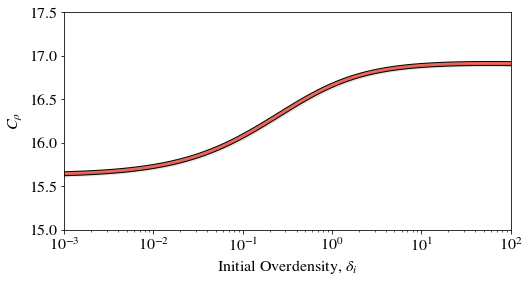

In [8]:
path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal(), 
              pe.SimpleLineShadow(alpha = 0.1, offset=(2,-2))]

Cx = xTAs*phis
Crho = 1/(RTAs*Cx)**3

CrhoInt = interp1d(np.log10(phis), Crho, kind = "cubic", bounds_error=False)

phiDummy = np.linspace(np.log10(min(phis)), np.log10(max(phis)), 100)

plt.figure(figsize = (8,4))
plt.semilogx(10**(phiDummy), CrhoInt(phiDummy), lw = 3, color = "#e96859", path_effects = path_effects)
plt.ylabel(r"$C_{\rho}$")
plt.xlabel("Initial Overdensity, $\delta_i$")
plt.xlim(min(phis), max(phis))
plt.ylim(15, 17.5)
plt.savefig("KT_Crho.pdf", bbox_inches = "tight")

(0.001, 100.0)

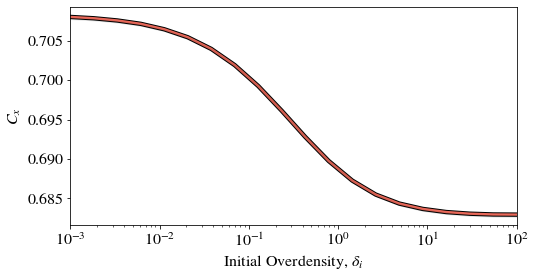

In [6]:
plt.figure(figsize = (8,4))
plt.semilogx(phis, Cx, lw = 2.4, color = "#e96859", path_effects = path_effects)
plt.ylabel(r"$C_{x}$")
plt.xlabel("Initial Overdensity, $\delta_i$")
plt.xlim(min(phis), max(phis))